In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2025-09-22 13:22:41.682177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758547361.970382      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758547362.055352      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
# Kaggle input altında brain tumor dataset'ini otomatik bulma (güvenli)
base = "/kaggle/input"
candidates = [d for d in os.listdir(base) if 'brain' in d.lower() or 'tumor' in d.lower()]
print("Bulunan adaylar:", candidates)
# örn: candidates[0] -> "/kaggle/input/masoudnickparvar-brain-tumor-mri-dataset"
DATA_ROOT = os.path.join(base, candidates[0]) if candidates else "../input/brain-tumor-mri-dataset/Brain Tumor MRI Dataset/"
print("DATA_ROOT:", DATA_ROOT)


Bulunan adaylar: ['brain-tumor-mri-dataset']
DATA_ROOT: /kaggle/input/brain-tumor-mri-dataset


In [8]:
import os
def build_dataframe_from_dir(base_dir):
    rows = []
    # bazen dataset 'Training' ve 'Testing' alt klasörlerini içerir
    for split in ["Training", "Testing"]:
        split_path = os.path.join(base_dir, split)
        if not os.path.exists(split_path):
            continue
        for cls in sorted(os.listdir(split_path)):
            cls_path = os.path.join(split_path, cls)
            if not os.path.isdir(cls_path): 
                continue
            for fname in os.listdir(cls_path):
                if fname.lower().endswith((".jpg",".jpeg",".png")):
                    rows.append({"filepath": os.path.join(cls_path, fname), "label": cls, "split": split})
    return pd.DataFrame(rows)

df_all = build_dataframe_from_dir(DATA_ROOT)
print("Toplam görüntü sayısı:", len(df_all))
df_all['label'].value_counts()


Toplam görüntü sayısı: 7023


label
notumor       2000
pituitary     1757
meningioma    1645
glioma        1621
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

train_df = df_all[df_all['split']=="Training"].copy()
test_df  = df_all[df_all['split']=="Testing"].copy()

# stratify ile sınıf dağılımını koru
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df['label'],
    random_state=42
)

# indeksleri sıfırla
train_df = train_df.reset_index(drop=True)
val_df   = val_df.reset_index(drop=True)
test_df  = test_df.reset_index(drop=True)

print("Train / Val / Test:", len(train_df), len(val_df), len(test_df))
print(train_df['label'].value_counts())


Train / Val / Test: 4569 1143 1311
label
notumor       1276
pituitary     1165
meningioma    1071
glioma        1057
Name: count, dtype: int64


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 128   # HIZ için: 64 ile başla; kalite/artırım için 128 veya 224 deneyebilirsin
BATCH_SIZE = 32
SEED = 42

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.10,
    height_shift_range=0.10,
    zoom_range=0.15,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=(IMG_SIZE,IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 4569 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


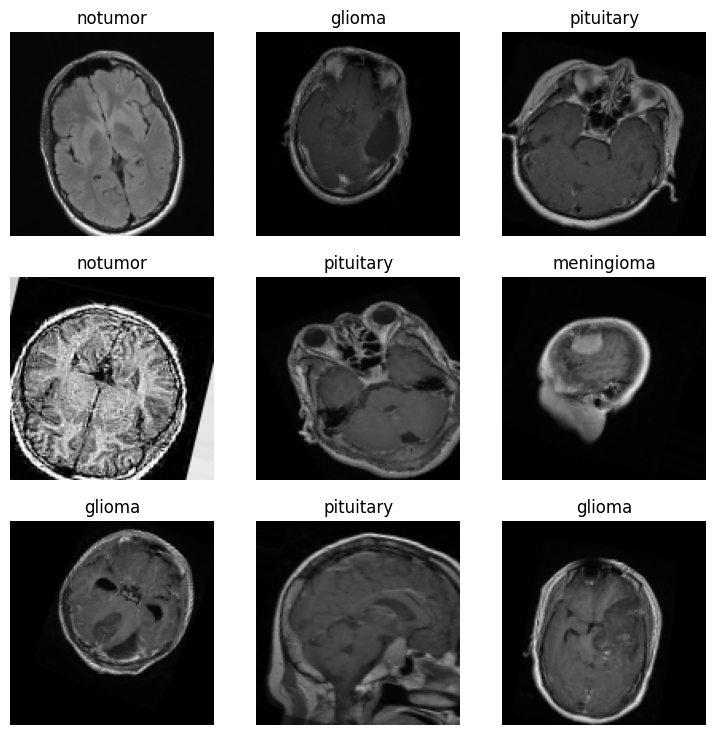

In [11]:
import matplotlib.pyplot as plt
batch_imgs, batch_labels = next(train_gen)   # batch_imgs: (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3)
plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(batch_imgs[i])
    plt.title(list(train_gen.class_indices.keys())[np.argmax(batch_labels[i])])
    plt.axis('off')
plt.show()


In [12]:
from sklearn.utils.class_weight import compute_class_weight
# Harici olarak train_df'deki etiketleri, train_gen.inices ile integer'a çevir:
label_to_index = train_gen.class_indices   # e.g. {'glioma':0, 'meningioma':1, ...}
labels_int = train_df['label'].map(label_to_index).values

class_weights_raw = compute_class_weight(class_weight='balanced', classes=np.unique(labels_int), y=labels_int)
class_weights = {int(cls): float(w) for cls, w in zip(np.unique(labels_int), class_weights_raw)}
print("Class weights:", class_weights)


Class weights: {0: 1.0806527909176915, 1: 1.0665266106442577, 2: 0.895180250783699, 3: 0.9804721030042919}


In [13]:
from PIL import Image
def validate_paths(df):
    ok=[]
    for p in df['filepath']:
        try:
            img = Image.open(p)
            img.verify()
            ok.append(p)
        except Exception:
            pass
    return ok


In [14]:
train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)


Found 4569 validated image filenames belonging to 4 classes.


In [15]:
print(train_gen.class_indices)


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [28]:
# --------------------------------------------
# 0) Gerekli Kütüphaneler
# --------------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np

# --------------------------------------------
# 1) Model Mimarisini Oluşturma
# --------------------------------------------
# Neden bu yapılar:
# - Conv2D: Görüntüden özellik (feature) çıkarır
# - MaxPooling2D: Önemli özellikleri yoğunlaştırır, overfitting azaltır
# - Dropout: Rastgele nöronları kapatarak modelin ezberlemesini engeller
# - BatchNormalization: Aktivasyonları normalize eder, eğitim stabilitesini artırır
# - Dense: Son sınıflandırma katmanı
# - Aktivasyonlar: ReLU (ara katman), Softmax (çok sınıflı çıktı)

num_classes = len(train_gen.class_indices)  # otomatik sınıf sayısı
IMG_SIZE = 128
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Dense layer'da daha yüksek dropout
    Dense(num_classes, activation='softmax')  # Çok sınıflı çıkış
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289,092 (16.36 MB)

 Trainable params: 4,288,644 (16.36 MB)

 Non-trainable params: 448 (1.75 KB)

In [29]:
# --------------------------------------------
# 2) Modeli Compile Etme
# --------------------------------------------
# Adam optimizer: yaygın, adaptif öğrenme
# Categorical Crossentropy: çok sınıflı sınıflandırma
# Metrics: accuracy (başarım ölçütü)

optimizer = Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [30]:
# --------------------------------------------
# 3) Callbacks (overfitting’i önlemek için)
# --------------------------------------------
# EarlyStopping: validation loss uzun süre düşmezse durdur
# ModelCheckpoint: en iyi model ağırlıklarını sakla
# ReduceLROnPlateau: plateau olduğunda learning rate düşür

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
]


In [31]:
# --------------------------------------------
# 4) Class Weights (opsiyonel ama önerilir)
# --------------------------------------------
from sklearn.utils.class_weight import compute_class_weight

label_to_index = train_gen.class_indices
labels_int = train_df['label'].map(label_to_index).values
class_weights_raw = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(labels_int),
                                         y=labels_int)
class_weights = {int(cls): float(w) for cls, w in zip(np.unique(labels_int), class_weights_raw)}
print("Class weights:", class_weights)


Class weights: {0: 1.0806527909176915, 1: 1.0665266106442577, 2: 0.895180250783699, 3: 0.9804721030042919}


In [14]:
import os

# Mevcut dizindeki tüm dosya ve klasörleri listele
print("Mevcut dizindeki içerik:")
for item in os.listdir('.'):
    print(item)

# Eğer dataset'in olabileceği belli bir üst dizin varsa
dataset_root = '.'  # veya '../', '/content/', vs.
for root, dirs, files in os.walk(dataset_root):
    for d in dirs:
        if 'train' in d.lower() or 'val' in d.lower() or 'dataset' in d.lower():
            print(f"Muhtemel dataset klasörü bulundu: {os.path.join(root, d)}")


Mevcut dizindeki içerik:
.virtual_documents


In [15]:
import os

# Mevcut dizindeki tüm klasörleri ve dosyaları listeler
for root, dirs, files in os.walk('.'):
    print("Current path:", root)
    print("Directories:", dirs)
    print("Files:", files)
    print("----------")


Current path: .
Directories: ['.virtual_documents']
Files: []
----------
Current path: ./.virtual_documents
Directories: []
Files: []
----------


In [18]:
train_dir = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/Training"
val_dir   = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/Testing"

print("Train klasörü:", train_dir)
print("Val klasörü:", val_dir)


Train klasörü: /kaggle/input/brain-mri-images-for-brain-tumor-detection/Training
Val klasörü: /kaggle/input/brain-mri-images-for-brain-tumor-detection/Testing


In [21]:
import os

# Kaggle input klasöründeki tüm datasetleri listele
print("Input dizinleri:", os.listdir("/kaggle/input"))


Input dizinleri: ['brain-tumor-mri-dataset']


In [23]:
import os

base_path = "/kaggle/input/brain-tumor-mri-dataset"

train_dir = os.path.join(base_path, "Training")
val_dir = os.path.join(base_path, "Testing")

print("Train klasörü:", train_dir)
print("Val klasörü:", val_dir)

print("Train içeriği:", os.listdir(train_dir))
print("Val içeriği:", os.listdir(val_dir))


Train klasörü: /kaggle/input/brain-tumor-mri-dataset/Training
Val klasörü: /kaggle/input/brain-tumor-mri-dataset/Testing
Train içeriği: ['pituitary', 'notumor', 'meningioma', 'glioma']
Val içeriği: ['pituitary', 'notumor', 'meningioma', 'glioma']


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Epoch 1/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 564ms/step - accuracy: 0.4728 - loss: 1.1377
Epoch 1: val_loss improved from inf to 0.97277, saving model to best_model.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 111s 607ms/step - accuracy: 0.4733 - loss: 1.1368 - val_accuracy: 0.6583 - val_loss: 0.9728 - learning_rate: 0.0010
Epoch 2/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.7073 - loss: 0.7357
Epoch 2: val_loss did not improve from 0.97277
179/179 ━━━━━━━━━━━━━━━━━━━━ 109s 605ms/step - accuracy: 0.7074 - loss: 0.7355 - val_accuracy: 0.6278 - val_loss: 1.1183 - learning_rate: 0.0010
Epoch 3/30
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 565ms/step - accuracy: 0.7614 - loss: 0.6209
Epoch 3: val_loss improved from 0.97277 to 0.74667, saving model to best_model.h5
179/179 ━━━━━━━━━━━━━━━━━━━━ 112s 623ms/step - accuracy: 0.7614 - loss: 0.6209 - val_accuracy: 0.6773 - val_loss: 0.7467 - learning_rate: 0.0010
Epoch 4/30

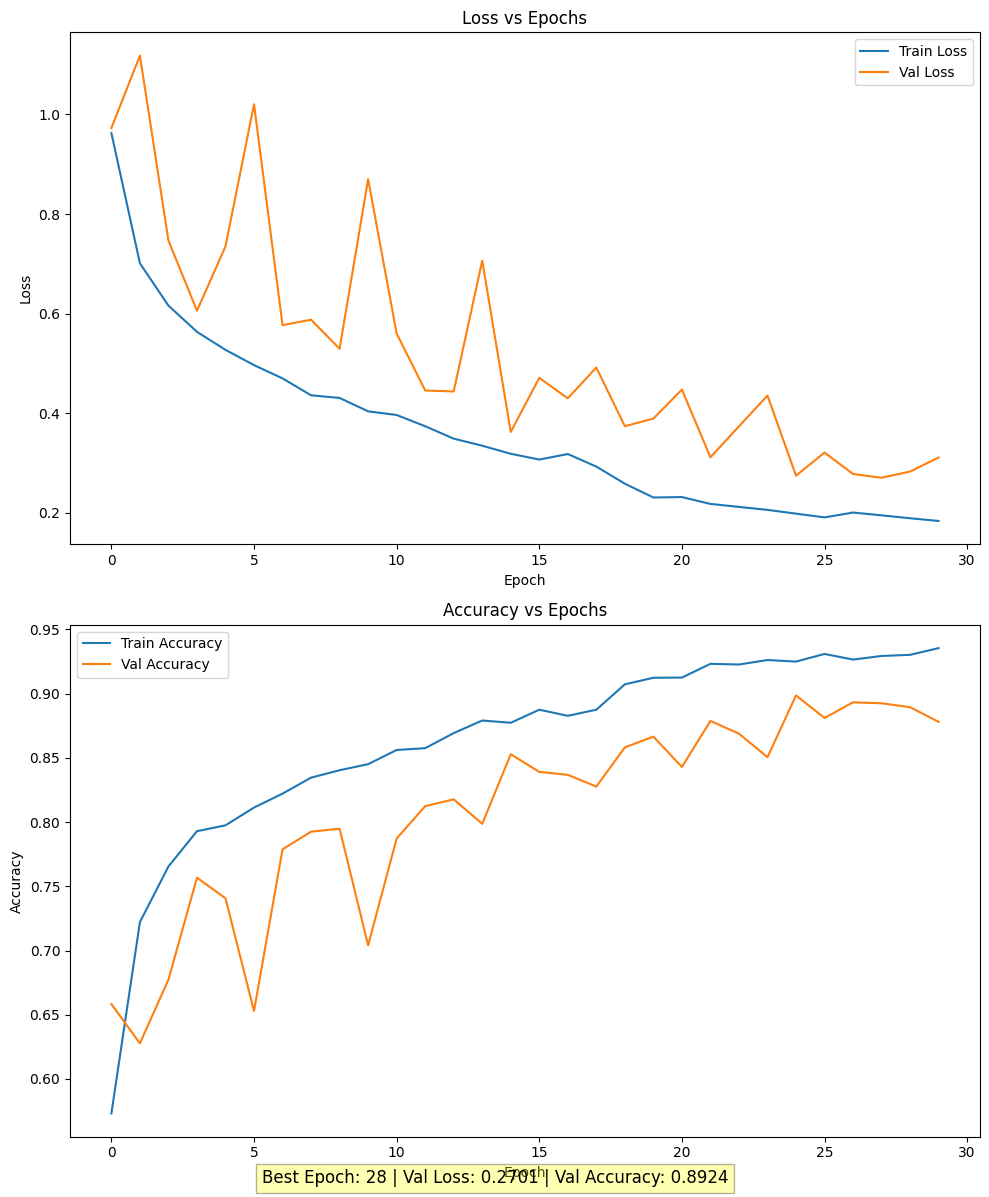

Tek görsel rapor kaydedildi: training_report.png


In [11]:
# -------------------------------
# 1. Kütüphaneler
# -------------------------------
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# -------------------------------
# 2. Veri yolları
# -------------------------------
train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
val_dir = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# -------------------------------
# 3. ImageDataGenerator
# -------------------------------
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical'
)

# -------------------------------
# 4. Model Tanımı
# -------------------------------
num_classes = 4
model = Sequential([
    Input(shape=(128,128,3)),  # input layer
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# -------------------------------
# 5. Callbacks
# -------------------------------
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# -------------------------------
# 6. Model Eğitimi
# -------------------------------
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,   # dilersen 50 yapabilirsin
    callbacks=[checkpoint, reduce_lr]
)

# -------------------------------
# 7. Model Kaydı
# -------------------------------
model.save("final_model.h5")
print("Eğitilmiş model kaydedildi: final_model.h5")

# -------------------------------
# 8. Eğitim Grafikleri ve Tek Görsel Rapor
# -------------------------------
plt.figure(figsize=(10,12))

# Loss ve Accuracy grafikleri
plt.subplot(2,1,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2,1,2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# En iyi epoch bilgisi
best_val_loss = min(history.history['val_loss'])
best_epoch = history.history['val_loss'].index(best_val_loss) + 1
best_val_acc = history.history['val_accuracy'][best_epoch-1]

plt.figtext(0.5, 0.01, f"Best Epoch: {best_epoch} | Val Loss: {best_val_loss:.4f} | Val Accuracy: {best_val_acc:.4f}",
            ha="center", fontsize=12, bbox=dict(facecolor='yellow', alpha=0.3))

plt.tight_layout()
plt.savefig("training_report.png")
plt.show()
print("Tek görsel rapor kaydedildi: training_report.png")
